# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **스파크 스트리밍(Spark Streaming)이란?**

SQL 엔진 위에 만들어진 분산 스트림 처리 프로세싱이다.

데이터 스트림을 처리할 때 사용한다.

시간대 별로 데이터를 합쳐(aggregate) 분석할 수 있다.

Kafka, Amazon Kinesis, Hdfs 등과 연결할 수 있다.

체크 포인트를 만들어서 부분적인 결함이 발생해도 다시 돌아가서 데이터를 처리할 수 있다.

**스트림 데이터(Streaming Data)**

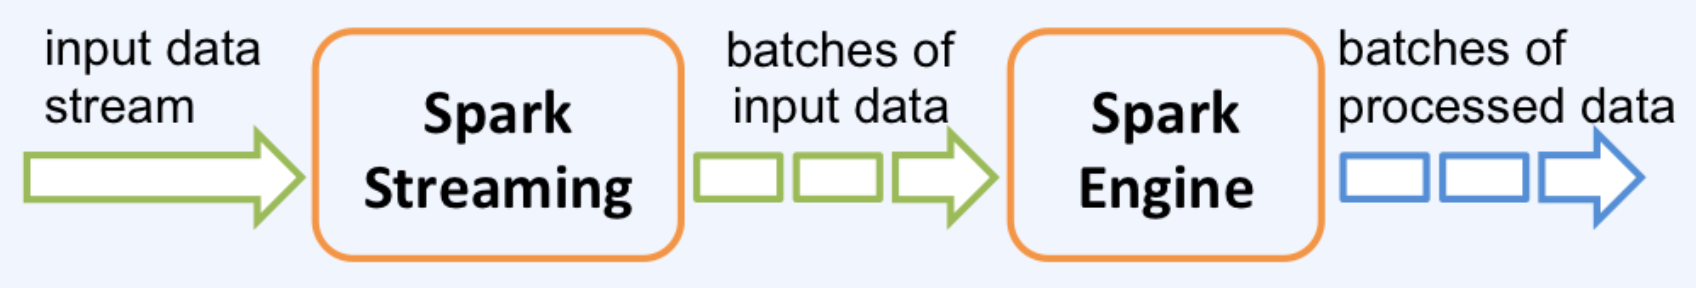

스트림 데이터는 하나의 무한한 테이블이다.

데이터가 무한할 때 처리할 수 있는 아이디어가 여러가지인데, 그 중 무한한 데이터를 잘 쪼개서 처리를 한다는 아이디어가 있다.

그것이 스파크 스트리밍의 기본적인 아이디어이다.

인풋 데이터 스트림(input data stream)이 무한하게 들어오면 리시버(receiver)가 받아서 잘게 쪼갠다. 그것을 마이크로 배칭(micro batching)이라고 한다.

배칭된 데이터를 스파크 엔진(Spark Engine)에 넘겨준다. 이를 데이터프레임과 비슷하게 처리할 수 있다.

**DStreams(Discretized Streams)**

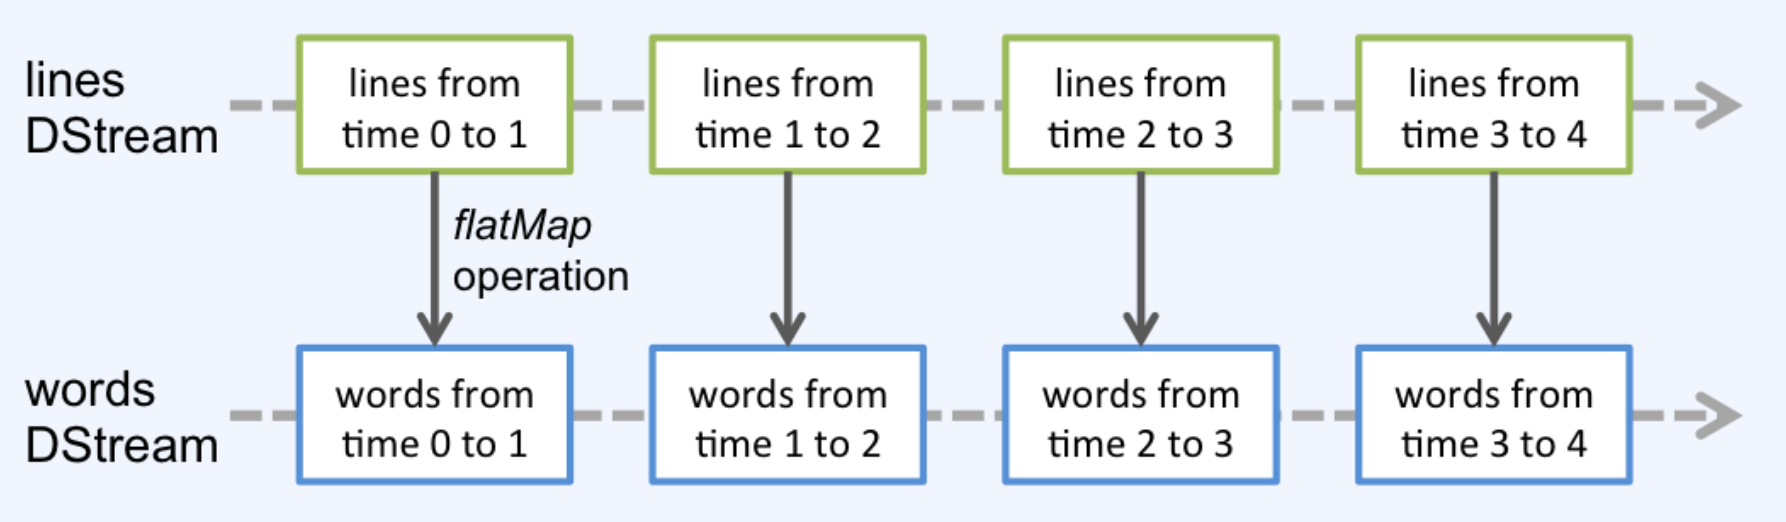

스파크 스트림의 기본적인 추상화이다.

스트림 데이터 이미지에서 배칭 된 데이터가 추상화 데이터이다.

내부적으론 RDD의 연속이고 RDD의 속성을 이어 받는다.

불변, 분산 저장 등의 속성이 있다.

디스트림(DStreams)도 하나의 트랜스포메이션(transformation)을 거쳐 새로운 디스트림을 만들 수 있다.

위 이미지를 보면, 데이터가 들어와서 하나의 디스트림을 만든다.

시간대 별로 스냅 사진을 찍어 데이터가 연속으로 정리된다.

디스트림의 트랜스포메이션을 거쳤을 때, 하나의 문장을 가진 RDD가 플랫 맵(flatMap)을 적용하면 각각의 단어가 나온다.

**윈도우 오퍼레이션(Window Operations)**

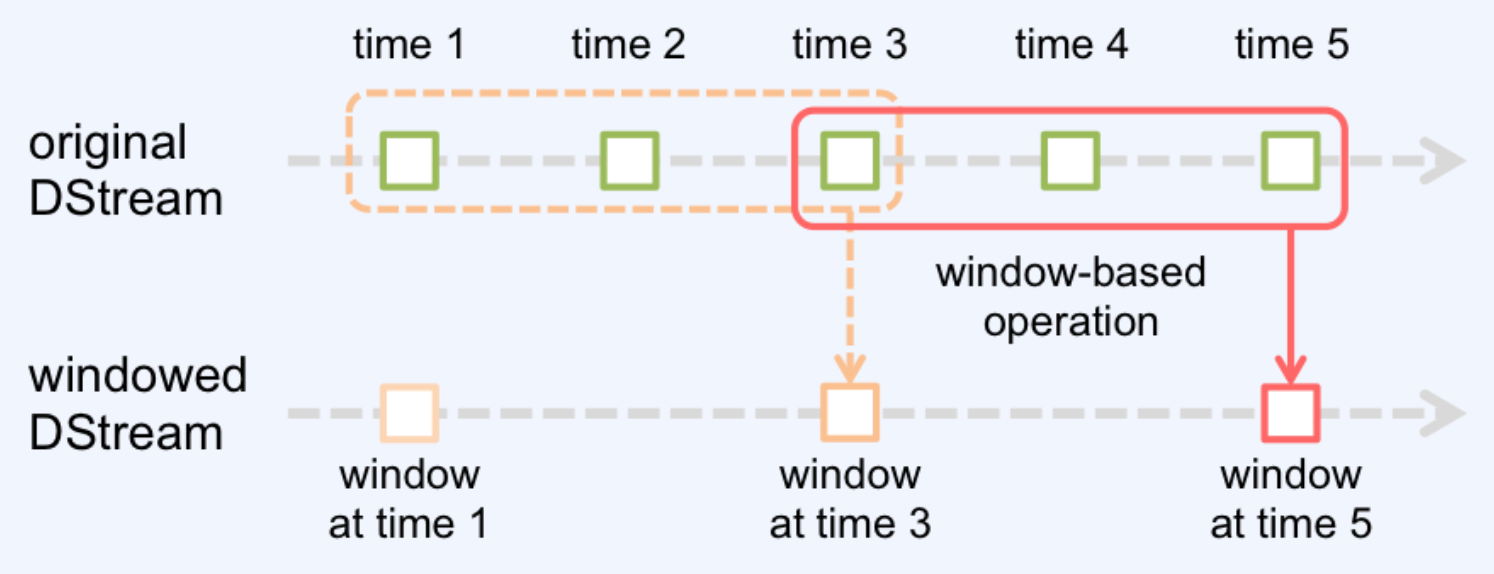

지금의 데이터를 처리하기 위해 이전 데이터에 대한 정보가 필요할 때 윈도우 오퍼레이션으로 데이터를 묶어서 처리한다.


**스트림 쿼리(Streaming Query)**

**Source**

데이터를 어디서 읽어올 지 명시한다.

여러 데이터 소스를 사용해 join()이나 union()으로 합쳐 쓸 수 있다.



```
spark.readStram.format('kafka')
    .option('kafka.bootstrap.server', ...)
    .option('subscribe', 'topic')
    .load()
```



**Transformation**




```
spark.readStream.format('kafka')
    .option('kafka.bootstrap.servers', ...)
    .option('subscribe', 'topic')
    .load()
    .selectExpr('cast (value as string) as json')
    .select(from_json('json', schema). As('data'))

```



**Processing Details**



```
spark.readStream.format('kafka')
    .option('kafka.bootstrap.servers', ...)
    .option('subscribe', 'topic')
    .load()
    .selectExpr('cast (value as string) as json')
    .select(from_json('json', schema). As('data'))
    .writeStream.format('parquet')
    .trigger('1 minute') # micro-batch 실행 간격
    .option('checkpointLocation', '...')
    .start()
```



**트랜스포메이션(trnasformations)**

Map

FlatMap

Filter

ReduceByKey


**스테이트(State)**

이전 데이터에 대한 정보를 스테이트로 주고 받을 수 있다.

예: 카테고리 별 총 합

**소스 코드 예제**

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# 스파크 인스턴스 생성
spark = SparkSession.builder.appName("stream-word-count").getOrCreate()

# 리드 스트림 명시
# 소켓으로부터 읽어오고 옵션으로 호스트와 포트 명시
lines_df = spark.readStream.format("socket").option("host", "localhost").option("port", "9999").load()

# 일반적인 df처럼 사용
# expr: sql문을 select안에서 사용할 수 있게 해주는 함수
# 공백 기준으로 스플릿을 한 후 explode하라는 코드
words_df = lines_df.select(expr("explode(split(value, ' ')) as word"))

# 쪼갠 워드를 카운트
counts_df = words_df.groupBy("word").count()

In [ ]:
# 콘솔로 내보낸다.
word_count_query = counts_df.writeStream.format("console")\
                            .outputMode("complete")\
                            .option("checkpointLocation", ".checkpoint")\
                            .start()
word_count_query.awaitTermination()

로컬로 터미널 에서` 'nc -1k 9999' `포트를 열어 주는 코드를 작성 하면 실시간 처리가 가능